<a href="https://colab.research.google.com/github/MaahirG/DepthDataApplication/blob/master/DepthCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

from google.colab import drive # https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/DepthML/DepthConfirmed/*"
imageList = glob.glob(path)
annotationMarker_Index = len(path) - 1   # -1 because list indexing starts at 0

master_list = []

for index,img in enumerate(imageList):
    n = cv2.imread(img)
    if n is None:
      print("Problematic Image! SKIP and do not add to dataset.")
      continue
    # Sort auto annotated image flags: 'n' , 'm' , 'D' from image filenames
    # imageList[index] returns a string
    label = imageList[index][annotationMarker_Index]

    if label == 's': 
        master_list.append((n,2))
    elif label == 'm':
        master_list.append((n,1))
    elif label == 'D': 
        master_list.append((n,0))
    else: 
        print("error getting marker label")
    
    print(label, n.shape, index)


# For downsizing later
scale_factor = 0.4 # of original size
height = int(master_list[0][0].shape[0] * 0.4) #tuple[0].shape[0] == 480 height
width = height
dim = (width, height)

print(master_list[0][1])
# Randomize the order of images - replaces the actual list
random.shuffle(master_list)
print(master_list[0][1])
shuffle_list = master_list

Streaming output truncated to the last 5000 lines.
D (480, 640, 3) 1420
D (480, 640, 3) 1421
D (480, 640, 3) 1422
D (480, 640, 3) 1423
s (480, 640, 3) 1424
D (480, 640, 3) 1425
D (480, 640, 3) 1426
D (480, 640, 3) 1427
D (480, 640, 3) 1428
D (480, 640, 3) 1429
D (480, 640, 3) 1430
D (480, 640, 3) 1431
D (480, 640, 3) 1432
D (480, 640, 3) 1433
D (480, 640, 3) 1434
D (480, 640, 3) 1435
D (480, 640, 3) 1436
D (480, 640, 3) 1437
D (480, 640, 3) 1438
D (480, 640, 3) 1439
D (480, 640, 3) 1440
D (480, 640, 3) 1441
D (480, 640, 3) 1442
D (480, 640, 3) 1443
D (480, 640, 3) 1444
D (480, 640, 3) 1445
m (480, 640, 3) 1446
D (480, 640, 3) 1447
D (480, 640, 3) 1448
D (480, 640, 3) 1449
D (480, 640, 3) 1450
D (480, 640, 3) 1451
D (480, 640, 3) 1452
D (480, 640, 3) 1453
D (480, 640, 3) 1454
D (480, 640, 3) 1455
D (480, 640, 3) 1456
m (480, 640, 3) 1457
D (480, 640, 3) 1458
D (480, 640, 3) 1459
D (480, 640, 3) 1460
D (480, 640, 3) 1461
D (480, 640, 3) 1462
D (480, 640, 3) 1463
D (480, 640, 3) 1464
m (4

In [ ]:
# Declare lists? Convert to numpy lists before? refactor CODE
print(len(master_list))
print(dim)
training_img = [] # training images
training_labs = [] # training labels
testing_img = []
testing_labs = []
# Splitting dataset into training and testing
# image is tupl[0], corresponding label is tupl[1]
# resize image even changes BGR values in the 3 channels to work with averaging multiple pixels for the resize of overall image
# physically resizing image into smaller dimensions (not reshaping array)
# reduced input layer(made up of each pixel) size by huge amount by resizing
for index,tupl in enumerate(shuffle_list[:int(len(shuffle_list)*0.8)]):
    print(index, tupl[1])
    resize = cv2.resize(tupl[0], dim, interpolation = cv2.INTER_AREA)
    training_img.append(resize)  # inter_area is best for downsizing
    training_labs.append(tupl[1])

# training and testing lists no have 80:20 split and the image vs labels are correctly corresponding index
for testTup in shuffle_list[int(len(shuffle_list)*0.8):len(shuffle_list)]:
    resize2 = cv2.resize(testTup[0], dim, interpolation = cv2.INTER_AREA)
    testing_img.append(resize2)
    testing_labs.append(testTup[1])

# print(len(training_img))
# print(len(training_labs))
# print(len(testing_img))
# print(len(testing_labs))

# arrays have a shape attribute that returns a tuple of the length of each dimension of the array
# 1 image = shape:(480,640,3), rows, cols, RGB per pixel

 # convert to numpy array for easier use with TF
training_data = np.asarray(training_img)
train_labels = np.asarray(training_labs) 
testing_data = np.asarray(testing_img) 
test_labels = np.asarray(testing_labs)

training_img.clear()
training_labs.clear()
testing_img.clear()
testing_labs.clear()
print(len(testing_labs))

classes = np.unique(train_labels) # array/list
nClasses = len(classes)
nRows,nCols,nDims = training_data.shape[1:] 
input_shape = (nRows, nCols, nDims)

print("Image 0 Shape:", training_data.shape[1:]) # should be resized
print("SHAPE:", nRows,nCols,nDims)

# RESHAPE DATA STRUCTURE ALREADY EXISTS FROM NP.ARRAY CONVERSION
# train_data = training_data.reshape(training_data.shape[0], nRows, nCols, nDims) # size, rows, cols, channels
# test_data = testing_data.reshape(training_data.shape[0], nRows, nCols, nDims)

# DATA STRUCTURE FROM RESHAPE
# [ Encompassing numpy array
#  [ 50k/Size/# of Total Images
#   [ In Each of 50k: nRows Size
#    [ In Each of nRowsSize: nColSize
#     [ In Each of nColSize: nDimsSize
     
#     ] 
#    ]
#   ]
#  ]
# ]

# Change to float datatype
train_data = training_data.astype('float32')
test_data = testing_data.astype('float32')

# Scale the data to lie between 0 to 1 - elementwise division of the whole array structure
train_data /= 255 
test_data /= 255 

# Example showing floating, proper reshaping of arrays, and value for NN between 0&1
print("RGB, PROPER RESHAPE AND SCALING:", train_data[3][69][191])


# USE CATEGORICAL CROSSENTROPY IF YOU ONE HOT, SPARSE IF THE CLASS IS JUST AN INTEGER.
# From a representation like train_labels[0] = 2 --> array: [0. 0. 1.]
# train_labels_one_hot = to_categorical(train_labels) 
# test_labels_one_hot = to_categorical(test_labels)



Streaming output truncated to the last 5000 lines.
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 1
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 1
178 0
179 0
180 0
181 0
182 0
183 1
184 0
185 2
186 0
187 0
188 0
189 0
190 0
191 2
192 0
193 0
194 0
195 0
196 0
197 0
198 0
199 0
200 0
201 0
202 0
203 0
204 0
205 0
206 0
207 0
208 0
209 0
210 0
211 0
212 0
213 0
214 0
215 0
216 0
217 0
218 0
219 0
220 0
221 0
222 0
223 1
224 0
225 0
226 0
227 0
228 0
229 0
230 0
231 0
232 0
233 0
234 0
235 0
236 0
237 0
238 0
239 0
240 0
241 0
242 0
243 0
244 0
245 0
246 0
247 0
248 1
249 0
250 0
251 0
252 0
253 0
254 0
255 0
256 0
257 0
258 0
259 0
260 0
261 0
262 0
263 0
264 0
265 0
266 0
267 0
268 0
269 0
270 0
271 0
272 0
273 0
274 0
275 0
276 1
277 0
278 0
279 1
280 0
281 0
282 0
283 0
284 0
285 0
286 0
287 0
288 0
289 0
290 0
291 0
292 0
2

In [ ]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    # kernel/filter dot products the same size area and gets a value --> relu that value
    # padding for some layers is 'same' beacuse it'll padd the same outer most adjacent value of the pixel
    # spatial volume is decreasing as number of filters learned is increasing

    # Stride size default: (1,1) start at cur, move over by 1 pixel
    # Strides of 2×2 can be a replacement to max pooling
    # 5x5x3 for RGB channels is implied in kernel declaration size Conv2D
    # stack all 32 or 64 etc feature maps together and that becomes the final output of the convolution layer
    # applying the kernel leaves the size of image the same VISUALIZATION: https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape)) 
    # with padding and kernel sliding, output size is the same as input: the padding takes care of the kernel sliding to remap the 1 pixel
    model.add(MaxPooling2D(pool_size=(3, 3))) # stride = 2 --> cut size to 1/3 --> # of total pixels / 9 --> gets a 3x3 space into 1 pixel then moves to next 3x3 space (no repeat because stride is 2)
    model.add(Dropout(0.25)) # sets 25% of pixels to 0 to prevent overfitting

    model.add(Conv2D(64, (5, 5), padding='same', activation='relu')) # NOTE CONVOLUTIONAL LAYERS WITH PADDING DON'T CHANGE SIZE - no matter size of the kernel (the padding 'same' accounts for that)
    model.add(MaxPooling2D(pool_size=(2, 2))) # 64x64x32 --> 4096 pixels / 4 --> 1024 --> 32x32x32
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Flatten the shrunken output which consists of one put together feature map of pixels
    model.add(Flatten()) # flatten layer - input layer to FC NN
    model.add(Dense(2048, activation='relu')) # number of hidden layer neurons should be half size of input layer.
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax')) # probabilistic values between 0 and 1
    
    return model


# Keras preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = createModel()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

batch_size = 1 # split dataset into batches of 256 images for so thus more steps per epoch, but 10 batches of x not as cumbersome as 1 batch of x*10 for 1 step   
epochs = 20

# Keras API Documentation: https://keras.io/api/preprocessing/image/
# Randomize actual image data for more robust feature extraction
datagen = ImageDataGenerator(
#         zoom_range=0.2, # randomly zoom into images
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


Epoch 1/20
5130/5130 [==============================] - 61s 12ms/step - loss: 0.4875 - accuracy: 0.9442 - val_loss: 0.2168 - val_accuracy: 0.9540
Epoch 2/20
5130/5130 [==============================] - 61s 12ms/step - loss: 0.3628 - accuracy: 0.9446 - val_loss: 0.2128 - val_accuracy: 0.9540
Epoch 3/20
5130/5130 [==============================] - 60s 12ms/step - loss: 0.3120 - accuracy: 0.9446 - val_loss: 0.2140 - val_accuracy: 0.9540
Epoch 4/20
5130/5130 [==============================] - 62s 12ms/step - loss: 0.2776 - accuracy: 0.9446 - val_loss: 0.2213 - val_accuracy: 0.9540
Epoch 5/20
5130/5130 [==============================] - 63s 12ms/step - loss: 0.2628 - accuracy: 0.9446 - val_loss: 0.2191 - val_accuracy: 0.9540
Epoch 6/20
5130/5130 [==============================] - 63s 12ms/step - loss: 0.2625 - accuracy: 0.9446 - val_loss: 0.2146 - val_accuracy: 0.9540
Epoch 7/20
5130/5130 [==============================] - 63s 12ms/step - loss: 0.4509 - accuracy: 0.9442 - val_loss: 0.2190 -

Text(0.5, 1.0, 'Accuracy Curves')

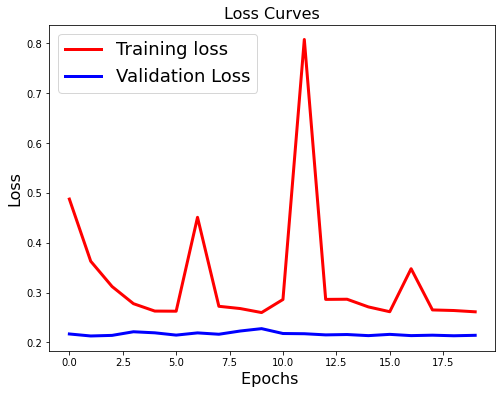

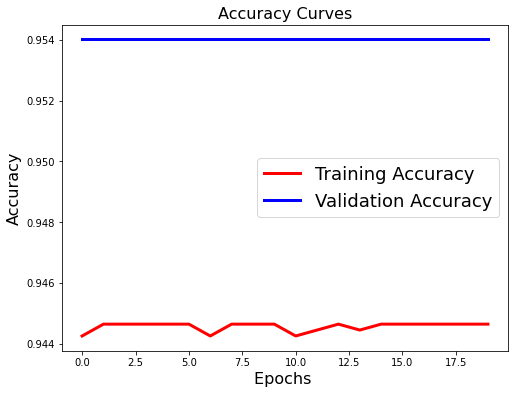

In [ ]:
# Fit the model on the randomized batches generated by datagen.flow().
# save to history_var (callback initiated each epoch that stores information about each epoch (dictionary)): https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
history_var = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                # number of total images / (# of images in a batch) = how many batches will have to pass through the CNN per epoch
                steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))), # steps means all batches are evaluated in a single epoch, just not all at once, successively.
                epochs=epochs,
                validation_data=(test_data, test_labels),
                verbose=1 # want training bar
                )

test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

model.summary()

print("\n\nMODEL TEST SET LOSS: ", test_loss)
print("MODEL TEST SET ACCURACY: ", test_accuracy)

# plots of training set loss and accuracy vs testing validation set val_loss and accuracy
plt.figure(figsize=[8,6])
plt.plot(history_var.history['loss'],'r',linewidth=3.0)
plt.plot(history_var.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)


plt.figure(figsize=[8,6])
plt.plot(history_var.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_var.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

IMAGE NUMBER: 0 
Confidence: 0.94267994
IMAGE NUMBER: 1 
Confidence: 0.94267994
IMAGE NUMBER: 2 
Confidence: 0.94267994
IMAGE NUMBER: 3 
Confidence: 0.94267994
[[0.94267994 0.04540825 0.01191174]
 [0.94267994 0.04540825 0.01191174]
 [0.94267994 0.04540825 0.01191174]
 [0.94267994 0.04540825 0.01191174]]


<Figure size 432x288 with 0 Axes>

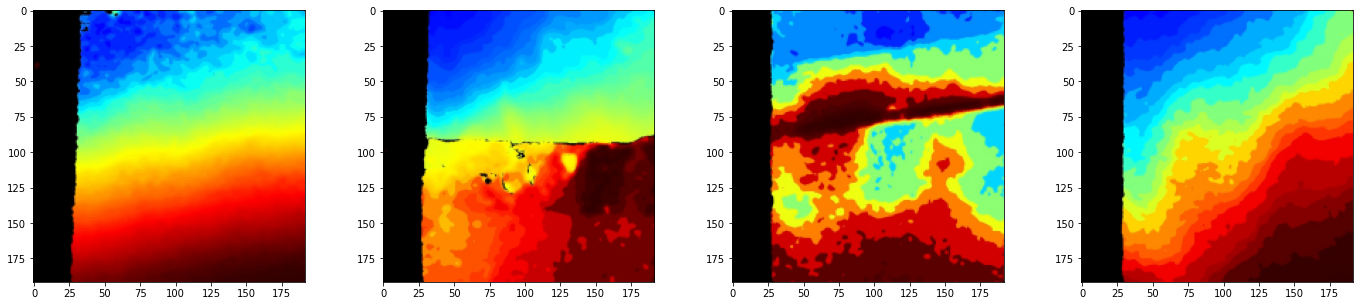

In [ ]:
predictionList = []
predictionPath = "/content/drive/My Drive/DepthML/PredictionSamples/*"
filenameList = glob.glob(predictionPath)
for filenames in filenameList:
  image = cv2.resize(cv2.imread(filenames), dim, interpolation = cv2.INTER_AREA)
  predictionList.append(image)

plt.figure()
figure, axesArray = plt.subplots(1, len(predictionList), figsize=(24, 5)) # subplot(row,col), figsize=(xnew,ynew)

for index in range(0,len(predictionList)):
  axesArray[index].imshow(predictionList[index])

# convert to models required input format - same as above
predictionList = np.asarray(predictionList)
predictionList = predictionList.astype('float32')
predictionList /= 255
# print("IMAGE SHAPE CHECK: ", image.shape)  

pred = model.predict(predictionList)
for imgNum,confidence in enumerate(pred):
  print("IMAGE NUMBER:", imgNum, "\nConfidence:", max(confidence))
print(pred)
